
# Advanced ML Modeling for Satellite Observation Success Prediction

## Goal
Optimize the best baseline model (XGBoost) through hyperparameter tuning and explore advanced techniques.

## Previous Results
- Best baseline model: XGBoost (85.0% accuracy, 92.4% ROC-AUC)
- Key features: station_lat, station_status, station_alt, horizon, experimental
- Dataset: 578K observations, 17 features after cleaning

## This Notebook Will:
1. Hyperparameter tuning for XGBoost (GridSearchCV, RandomizedSearchCV)
2. Cross-validation strategies
3. Advanced models: LightGBM, CatBoost
4. Ensemble methods: Stacking, Voting
5. Neural Network (simple MLP)
6. Feature selection based on importance
7. Final model selection and evaluation

## Expected Outputs:
- Optimized XGBoost model with improved performance
- Comparison of advanced models
- Feature selection recommendations
- Final model ready for deployment

In [2]:
# ============================================================================
# SIMPLE IMPORT SECTION - NO AUTO-INSTALL
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os
import time
import pickle
import json

print("="*80)
print("🤖 ADVANCED ML MODELING FOR SATELLITE OBSERVATION PREDICTION")
print("="*80)
print(f"Execution started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Working directory: {os.getcwd()}")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Create output directory
advanced_output_dir = "ml_results/advanced"
os.makedirs(advanced_output_dir, exist_ok=True)
print(f"Output directory created: {advanced_output_dir}")

# ============================================================================
# TRY IMPORTS WITH GRACEFUL FALLBACKS
# ============================================================================
print("\n🔍 Importing ML libraries...")

# Try to import XGBoost (should work since we used it before)
try:
    from xgboost import XGBClassifier
    print("✅ XGBoost imported successfully")
except ImportError:
    print("❌ XGBoost not found. Please install with: pip install xgboost")
    raise

# Try to import scikit-learn (should work)
try:
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.feature_selection import SelectFromModel
    from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                               f1_score, roc_auc_score, confusion_matrix, 
                               classification_report, roc_curve)
    print("✅ scikit-learn imported successfully")
except ImportError:
    print("❌ scikit-learn not found. Please install with: pip install scikit-learn")
    raise

# Try LightGBM (should work since it installed)
try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
    print("✅ LightGBM imported successfully")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠️  LightGBM not available. Skipping LightGBM models.")
    # Create a simple placeholder
    class LGBMClassifier:
        def __init__(self, **kwargs):
            self.params = kwargs
            self.available = False
        
        def fit(self, X, y):
            print("⚠️  LightGBM not installed. Skipping.")
            return self
        
        def predict(self, X):
            return np.zeros(len(X))
        
        def predict_proba(self, X):
            return np.zeros((len(X), 2))

# Try CatBoost (will likely fail)
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
    print("✅ CatBoost imported successfully")
except ImportError:
    CATBOOST_AVAILABLE = False
    print("⚠️  CatBoost not available. Skipping CatBoost models.")
    # Create a simple placeholder
    class CatBoostClassifier:
        def __init__(self, **kwargs):
            self.params = kwargs
            self.available = False
        
        def fit(self, X, y):
            print("⚠️  CatBoost not installed. Skipping.")
            return self
        
        def predict(self, X):
            return np.zeros(len(X))
        
        def predict_proba(self, X):
            return np.zeros((len(X), 2))

print(f"\n📊 Package Status:")
print(f"  • XGBoost:     Available ✅")
print(f"  • LightGBM:    {'Available ✅' if LIGHTGBM_AVAILABLE else 'Not available ⚠️'}")
print(f"  • CatBoost:    {'Available ✅' if CATBOOST_AVAILABLE else 'Not available ⚠️'}")

print("\n" + "="*80)
print("READY TO START ADVANCED MODELING")
print("="*80)

🤖 ADVANCED ML MODELING FOR SATELLITE OBSERVATION PREDICTION
Execution started: 2025-12-12 19:43:39
Working directory: d:\ELO 2\satnogs_project\satellite-pass-prediction\4_data_analysis
Output directory created: ml_results/advanced

🔍 Importing ML libraries...
✅ XGBoost imported successfully
✅ scikit-learn imported successfully
✅ LightGBM imported successfully
⚠️  CatBoost not available. Skipping CatBoost models.

📊 Package Status:
  • XGBoost:     Available ✅
  • LightGBM:    Available ✅
  • CatBoost:    Not available ⚠️

READY TO START ADVANCED MODELING


In [ ]:
# ============================================================================
# STEP 1 : LOAD DATA 
# ============================================================================
print("\n" + "="*80)
print("STEP 1 (FIXED): RELOADING DATA WITH CORRECT TARGET 'target_success'")
print("="*80)

print("Loading dataset with correct target column...")

# Load the dataset
df_fixed = pd.read_csv("../1_datasets/processed/four_year_observations_20251211_1730.csv")
print(f"✅ Dataset loaded: {df_fixed.shape}")

# Set the correct target column
correct_target = 'target_success'
print(f"🎯 Target column: {correct_target}")
print(f"   • Success rate: {df_fixed[correct_target].mean():.4f} ({df_fixed[correct_target].mean()*100:.1f}%)")
print(f"   • Matches baseline: {abs(df_fixed[correct_target].mean() - 0.4933) < 0.01}")

# ----------------------------------------------------------------------------
# Prepare Features (Remove problematic columns)
# ----------------------------------------------------------------------------
print("\n⚙️  Preparing features...")

# Columns to REMOVE (from baseline analysis and data inspection)
columns_to_remove = [
    # Leakage columns (directly related to target)
    'status',           # Perfectly predicts target (0 = success, -100/-1000 = failure)
    'status_category',  # Derived from status
    'waterfall_status', # Related to observation quality
    'vetted_status',    # Mostly 'unknown', not useful
    
    # Identifiers and metadata
    'id', 'start', 'end', 'archive_url', 'client_version',
    'station_name', 'grid_square', 'station_description', 'last_seen',
    
    # Redundant or problematic
    'sat_id', 'ground_station_id', 'station_id',  # Could cause overfitting to specific stations/satellites
    
    # Time features we'll recreate
    'time_of_day', 'season', 'elevation_category', 'duration_category', 'azimuth_range'
]

# Keep only columns that are not in the removal list and not the target
features = [col for col in df_fixed.columns 
            if col != correct_target and col not in columns_to_remove]

print(f"   • Total features available: {len(features)}")
print(f"   • Columns removed: {len(columns_to_remove)}")

# Create feature matrix and target vector
X = df_fixed[features].copy()
y = df_fixed[correct_target].copy()

print(f"\n📊 Data prepared:")
print(f"   • X shape: {X.shape}")
print(f"   • y shape: {y.shape}")
print(f"   • Success rate: {y.mean():.4f}")

# ----------------------------------------------------------------------------
# Display Feature Information
# ----------------------------------------------------------------------------
print("\n🔍 Feature categories:")

# Categorize features
feature_categories = {
    'Geographic': [],
    'Temporal': [],
    'Satellite/Orbit': [],
    'Station': [],
    'Observation': [],
    'Other': []
}

for feature in features:
    feature_lower = feature.lower()
    if any(geo in feature_lower for geo in ['lat', 'lng', 'lon', 'long', 'alt']):
        feature_categories['Geographic'].append(feature)
    elif any(time in feature_lower for time in ['hour', 'day', 'month', 'week', 'year']):
        feature_categories['Temporal'].append(feature)
    elif any(sat in feature_lower for sat in ['altitude', 'azimuth', 'rise', 'set', 'max']):
        feature_categories['Satellite/Orbit'].append(feature)
    elif 'station' in feature_lower:
        feature_categories['Station'].append(feature)
    elif any(obs in feature_lower for obs in ['duration', 'archive', 'experiment']):
        feature_categories['Observation'].append(feature)
    else:
        feature_categories['Other'].append(feature)

for category, cat_features in feature_categories.items():
    if cat_features:
        print(f"   • {category}: {len(cat_features)} features")
        if len(cat_features) <= 5:
            print(f"     {cat_features}")

# ----------------------------------------------------------------------------
# Split Data (Same as Baseline: 70/15/15)
# ----------------------------------------------------------------------------
print(f"\n📊 Creating train/validation/test splits (70/15/15)...")

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

val_ratio = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_ratio, random_state=42, stratify=y_temp
)

print(f"\n✅ Data splits created:")
print(f"   • Training:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   • Validation: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   • Test:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   • Total:      {len(X):,} samples")

print(f"\n📈 Success rates across splits:")
print(f"   • Train:     {y_train.mean():.4f} ({y_train.sum():,} successful)")
print(f"   • Validation:{y_val.mean():.4f} ({y_val.sum():,} successful)")
print(f"   • Test:      {y_test.mean():.4f} ({y_test.sum():,} successful)")

# ----------------------------------------------------------------------------
# Save Data for Future Use
# ----------------------------------------------------------------------------
print(f"\n💾 Saving fixed data...")

# Create a fresh output directory
fixed_output_dir = f"{advanced_output_dir}/fixed_data"
os.makedirs(fixed_output_dir, exist_ok=True)

# Save features
X_train.to_csv(f"{fixed_output_dir}/X_train.csv", index=False)
X_val.to_csv(f"{fixed_output_dir}/X_val.csv", index=False)
X_test.to_csv(f"{fixed_output_dir}/X_test.csv", index=False)

# Save targets (as numpy arrays for consistency)
np.save(f"{fixed_output_dir}/y_train.npy", y_train.values)
np.save(f"{fixed_output_dir}/y_val.npy", y_val.values)
np.save(f"{fixed_output_dir}/y_test.npy", y_test.values)

# Save feature names and metadata
with open(f"{fixed_output_dir}/features.json", 'w') as f:
    json.dump(features, f)

metadata = {
    'dataset': 'four_year_observations_20251211_1730.csv',
    'target_column': correct_target,
    'success_rate': float(y.mean()),
    'train_samples': int(X_train.shape[0]),
    'val_samples': int(X_val.shape[0]),
    'test_samples': int(X_test.shape[0]),
    'n_features': int(X_train.shape[1]),
    'split_random_state': 42,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'columns_removed': columns_to_remove
}

with open(f"{fixed_output_dir}/metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✅ Fixed data saved to: {fixed_output_dir}/")
print(f"   • X_train.csv, X_val.csv, X_test.csv")
print(f"   • y_train.npy, y_val.npy, y_test.npy")
print(f"   • features.json, metadata.json")

# ----------------------------------------------------------------------------
# Quick Sanity Check
# ----------------------------------------------------------------------------
print(f"\n🔍 Quick sanity check...")

# Check if we have the key features from baseline
key_baseline_features = ['station_lat', 'station_status', 'station_alt', 'horizon', 'experimental']
missing_features = [f for f in key_baseline_features if f not in features]
if missing_features:
    print(f"⚠️  Missing key baseline features: {missing_features}")
else:
    print(f"✅ All key baseline features present")

# Check data types
print(f"\n📊 Data types:")
print(f"   • Numeric: {len(X_train.select_dtypes(include=['int64', 'float64']).columns)}")
print(f"   • Object:  {len(X_train.select_dtypes(include=['object']).columns)}")

# Check for missing values
missing_train = X_train.isnull().sum().sum()
missing_val = X_val.isnull().sum().sum()
missing_test = X_test.isnull().sum().sum()

if missing_train + missing_val + missing_test > 0:
    print(f"⚠️  Missing values found:")
    print(f"   • Train: {missing_train}")
    print(f"   • Val:   {missing_val}")
    print(f"   • Test:  {missing_test}")
else:
    print(f"✅ No missing values")

print(f"\n" + "="*80)
print("STEP 1 COMPLETE: DATA FIXED AND READY!")
print("="*80)

print(f"\n✅ Data successfully reloaded with correct target 'target_success'")
print(f"   • Success rate: {y.mean():.4f} (matches baseline)")
print(f"   • Features: {X_train.shape[1]}")
print(f"   • Training samples: {X_train.shape[0]:,}")

print(f"\n🎯 Next: Run Step 2 (Feature Engineering) with the fixed data!")
print(f"   Use X_train, X_val, X_test, y_train, y_val, y_test from this step")


STEP 1 (FIXED): RELOADING DATA WITH CORRECT TARGET 'target_success'
Loading dataset with correct target column...
✅ Dataset loaded: (578010, 39)
🎯 Target column: target_success
   • Success rate: 0.4946 (49.5%)
   • Matches baseline: True

⚙️  Preparing features...
   • Total features available: 17
   • Columns removed: 21

📊 Data prepared:
   • X shape: (578010, 17)
   • y shape: (578010,)
   • Success rate: 0.4946

🔍 Feature categories:
   • Geographic: 4 features
     ['max_altitude', 'station_lat', 'station_lng', 'station_alt']
   • Temporal: 6 features
   • Satellite/Orbit: 2 features
     ['rise_azimuth', 'set_azimuth']
   • Station: 1 features
     ['station_status']
   • Observation: 3 features
     ['archived', 'experimental', 'duration_seconds']
   • Other: 1 features
     ['horizon']

📊 Creating train/validation/test splits (70/15/15)...

✅ Data splits created:
   • Training:   404,606 samples (70.0%)
   • Validation: 86,702 samples (15.0%)
   • Test:       86,702 samples (

In [16]:
# ============================================================================
# STEP 2 : FEATURE ENGINEERING 
# ============================================================================
print("\n" + "="*80)
print("STEP 2: FEATURE ENGINEERING WITH FIXED DATA")
print("="*80)

print("Applying essential feature engineering...")

# Create copies for feature engineering
X_train_fe = X_train.copy()
X_val_fe = X_val.copy()
X_test_fe = X_test.copy()

print(f"\n🔍 Original features: {X_train_fe.shape[1]}")

# ----------------------------------------------------------------------------
# 1. Basic Feature Engineering
# ----------------------------------------------------------------------------
print("\n1️⃣ Creating basic engineered features...")

# Check what features we have
print(f"   Available features: {list(X_train_fe.columns)[:15]}...")

# Create some basic features if the raw data is available
if 'max_altitude' in X_train_fe.columns:
    # Altitude features (important from baseline)
    X_train_fe['altitude_squared'] = X_train_fe['max_altitude'] ** 2
    X_val_fe['altitude_squared'] = X_val_fe['max_altitude'] ** 2
    X_test_fe['altitude_squared'] = X_test_fe['max_altitude'] ** 2
    
    X_train_fe['altitude_log'] = np.log1p(X_train_fe['max_altitude'])
    X_val_fe['altitude_log'] = np.log1p(X_val_fe['max_altitude'])
    X_test_fe['altitude_log'] = np.log1p(X_test_fe['max_altitude'])
    print(f"   ✅ Created altitude features")

if 'hour_of_day' in X_train_fe.columns:
    # Cyclic time encoding
    X_train_fe['hour_sin'] = np.sin(2 * np.pi * X_train_fe['hour_of_day'] / 24)
    X_train_fe['hour_cos'] = np.cos(2 * np.pi * X_train_fe['hour_of_day'] / 24)
    X_val_fe['hour_sin'] = np.sin(2 * np.pi * X_val_fe['hour_of_day'] / 24)
    X_val_fe['hour_cos'] = np.cos(2 * np.pi * X_val_fe['hour_of_day'] / 24)
    X_test_fe['hour_sin'] = np.sin(2 * np.pi * X_test_fe['hour_of_day'] / 24)
    X_test_fe['hour_cos'] = np.cos(2 * np.pi * X_test_fe['hour_of_day'] / 24)
    print(f"   ✅ Created cyclic hour features")

if 'month' in X_train_fe.columns:
    # Cyclic month encoding
    X_train_fe['month_sin'] = np.sin(2 * np.pi * X_train_fe['month'] / 12)
    X_train_fe['month_cos'] = np.cos(2 * np.pi * X_train_fe['month'] / 12)
    X_val_fe['month_sin'] = np.sin(2 * np.pi * X_val_fe['month'] / 12)
    X_val_fe['month_cos'] = np.cos(2 * np.pi * X_val_fe['month'] / 12)
    X_test_fe['month_sin'] = np.sin(2 * np.pi * X_test_fe['month'] / 12)
    X_test_fe['month_cos'] = np.cos(2 * np.pi * X_test_fe['month'] / 12)
    print(f"   ✅ Created cyclic month features")

if 'station_lat' in X_train_fe.columns:
    # Geographic features
    X_train_fe['abs_latitude'] = np.abs(X_train_fe['station_lat'])
    X_val_fe['abs_latitude'] = np.abs(X_val_fe['station_lat'])
    X_test_fe['abs_latitude'] = np.abs(X_test_fe['station_lat'])
    print(f"   ✅ Created absolute latitude")

# ----------------------------------------------------------------------------
# 2. Handle Categorical Features
# ----------------------------------------------------------------------------
print("\n2️⃣ Handling categorical features...")

# Identify categorical columns
categorical_cols = X_train_fe.select_dtypes(include=['object', 'category']).columns.tolist()

if categorical_cols:
    print(f"   Found {len(categorical_cols)} categorical features: {categorical_cols}")
    
    # For now, let's use simple label encoding for simplicity
    from sklearn.preprocessing import LabelEncoder
    
    for col in categorical_cols:
        # Combine train and val to get all categories
        combined = pd.concat([X_train_fe[col], X_val_fe[col], X_test_fe[col]])
        le = LabelEncoder()
        le.fit(combined)
        
        X_train_fe[col] = le.transform(X_train_fe[col])
        X_val_fe[col] = le.transform(X_val_fe[col])
        X_test_fe[col] = le.transform(X_test_fe[col])
    
    print(f"   ✅ Applied label encoding to categorical features")
else:
    print(f"   ✅ No categorical features found")

# ----------------------------------------------------------------------------
# 3. Fill Missing Values
# ----------------------------------------------------------------------------
print("\n3️⃣ Handling missing values...")

# Check for missing values
missing_train = X_train_fe.isnull().sum().sum()
missing_val = X_val_fe.isnull().sum().sum()
missing_test = X_test_fe.isnull().sum().sum()

if missing_train + missing_val + missing_test > 0:
    print(f"   Found missing values: Train={missing_train}, Val={missing_val}, Test={missing_test}")
    
    # Fill with median for numeric columns
    for col in X_train_fe.columns:
        if X_train_fe[col].dtype in ['int64', 'float64']:
            median_val = X_train_fe[col].median()
            X_train_fe[col].fillna(median_val, inplace=True)
            X_val_fe[col].fillna(median_val, inplace=True)
            X_test_fe[col].fillna(median_val, inplace=True)
    
    print(f"   ✅ Filled missing values with median")
else:
    print(f"   ✅ No missing values")

# ----------------------------------------------------------------------------
# 4. Save Engineered Features
# ----------------------------------------------------------------------------
print(f"\n💾 Saving engineered features...")

# Save to the fixed data directory
X_train_fe.to_csv(f"{fixed_output_dir}/X_train_engineered.csv", index=False)
X_val_fe.to_csv(f"{fixed_output_dir}/X_val_engineered.csv", index=False)
X_test_fe.to_csv(f"{fixed_output_dir}/X_test_engineered.csv", index=False)

print(f"\n📊 Feature Engineering Summary:")
print(f"   • Original features: {X_train.shape[1]}")
print(f"   • Engineered features: {X_train_fe.shape[1]}")
print(f"   • New features added: {X_train_fe.shape[1] - X_train.shape[1]}")

print(f"\n✅ Feature engineering complete!")
print(f"   Files saved to: {fixed_output_dir}/")

print(f"\n🎯 Next: Run hyperparameter tuning with the correct data!")


STEP 2: FEATURE ENGINEERING WITH FIXED DATA
Applying essential feature engineering...

🔍 Original features: 17

1️⃣ Creating basic engineered features...
   Available features: ['max_altitude', 'rise_azimuth', 'set_azimuth', 'archived', 'experimental', 'year', 'station_lat', 'station_lng', 'station_alt', 'horizon', 'station_status', 'duration_seconds', 'hour_of_day', 'day_of_week', 'month']...
   ✅ Created altitude features
   ✅ Created cyclic hour features
   ✅ Created cyclic month features
   ✅ Created absolute latitude

2️⃣ Handling categorical features...
   ✅ No categorical features found

3️⃣ Handling missing values...
   ✅ No missing values

💾 Saving engineered features...

📊 Feature Engineering Summary:
   • Original features: 17
   • Engineered features: 24
   • New features added: 7

✅ Feature engineering complete!
   Files saved to: ml_results/advanced/fixed_data/

🎯 Next: Run hyperparameter tuning with the correct data!


In [18]:
# ============================================================================
# STEP 3 (FIXED): HYPERPARAMETER TUNING WITH CORRECT DATA
# ============================================================================
print("\n" + "="*80)
print("STEP 3: HYPERPARAMETER TUNING WITH FIXED DATA")
print("="*80)

print("Loading the fixed and engineered data...")

# Load the engineered features from Step 2
fixed_data_dir = "ml_results/advanced/fixed_data"

# Load engineered features
X_train_engineered = pd.read_csv(f"{fixed_data_dir}/X_train_engineered.csv")
X_val_engineered = pd.read_csv(f"{fixed_data_dir}/X_val_engineered.csv")
X_test_engineered = pd.read_csv(f"{fixed_data_dir}/X_test_engineered.csv")

# Load target arrays
y_train_fixed = np.load(f"{fixed_data_dir}/y_train.npy")
y_val_fixed = np.load(f"{fixed_data_dir}/y_val.npy")
y_test_fixed = np.load(f"{fixed_data_dir}/y_test.npy")

print(f"✅ Data loaded successfully:")
print(f"   • X_train: {X_train_engineered.shape}")
print(f"   • X_val:   {X_val_engineered.shape}")
print(f"   • X_test:  {X_test_engineered.shape}")
print(f"   • y_train: {y_train_fixed.shape}")
print(f"   • Success rate: {y_train_fixed.mean():.4f}")

# ----------------------------------------------------------------------------
# 3.1 Set Up Hyperparameter Tuning
# ----------------------------------------------------------------------------
print("\n🔧 Setting up hyperparameter tuning...")

# Better hyperparameter ranges for your dataset
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1.0, 5.0]
}

print(f"   • Hyperparameters to tune: {len(xgb_param_grid)}")
print(f"   • Parameter combinations to sample: 20")

# ----------------------------------------------------------------------------
# 3.2 Create Base Model
# ----------------------------------------------------------------------------
print("\n🤖 Creating XGBoost model...")

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = len(y_train_fixed[y_train_fixed == 0]) / len(y_train_fixed[y_train_fixed == 1])
print(f"   • Class imbalance ratio: {scale_pos_weight:.2f}")

xgb_base = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    verbosity=0,
    scale_pos_weight=scale_pos_weight
)

# ----------------------------------------------------------------------------
# 3.3 Set Up RandomizedSearchCV
# ----------------------------------------------------------------------------
print("\n🎯 Setting up RandomizedSearchCV...")

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_grid,
    n_iter=20,  # Sample 20 combinations
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

# ----------------------------------------------------------------------------
# 3.4 Run Hyperparameter Tuning
# ----------------------------------------------------------------------------
print("\n🚀 Starting hyperparameter tuning...")
print(f"   • Training samples: {X_train_engineered.shape[0]:,}")
print(f"   • Features: {X_train_engineered.shape[1]}")
print(f"   • This may take 5-10 minutes...")

start_time = time.time()

# Use a sample for faster tuning (since we have 404K samples)
sample_size = min(50000, X_train_engineered.shape[0])
print(f"\n⚠️  Using {sample_size:,} samples for faster tuning...")

sample_indices = np.random.choice(X_train_engineered.shape[0], size=sample_size, replace=False)
X_tuning_sample = X_train_engineered.iloc[sample_indices]
y_tuning_sample = y_train_fixed[sample_indices]

print(f"   • Sample success rate: {y_tuning_sample.mean():.4f}")

# Run the tuning
xgb_random_search.fit(X_tuning_sample, y_tuning_sample)

tuning_time = time.time() - start_time
print(f"\n✅ Hyperparameter tuning completed in {tuning_time:.2f} seconds ({tuning_time/60:.1f} minutes)")

# ----------------------------------------------------------------------------
# 3.5 Display Results
# ----------------------------------------------------------------------------
print(f"\n🏆 Best Parameters Found:")
best_params = xgb_random_search.best_params_
for param, value in best_params.items():
    print(f"   • {param}: {value}")

print(f"\n📊 Best Cross-Validation Score: {xgb_random_search.best_score_:.4f} (ROC-AUC)")

# ----------------------------------------------------------------------------
# 3.6 Analyze Results
# ----------------------------------------------------------------------------
print("\n📈 Analyzing tuning results...")

cv_results = pd.DataFrame(xgb_random_search.cv_results_)
cv_results_sorted = cv_results.sort_values('mean_test_score', ascending=False)

print(f"\n📊 Top 3 parameter combinations:")
for i in range(3):
    row = cv_results_sorted.iloc[i]
    print(f"\n   {i+1}. ROC-AUC: {row['mean_test_score']:.4f}")
    print(f"      Parameters: {row['params']}")

# Check for overfitting
best_gap = cv_results_sorted.iloc[0]['mean_train_score'] - cv_results_sorted.iloc[0]['mean_test_score']
if best_gap > 0.05:
    print(f"\n⚠️  Potential overfitting (gap: {best_gap:.4f})")
else:
    print(f"\n✅ Good generalization (gap: {best_gap:.4f})")

# ----------------------------------------------------------------------------
# 3.7 Quick Test with Best Parameters
# ----------------------------------------------------------------------------
print("\n🔍 Quick test with best parameters on validation set...")

xgb_quick = XGBClassifier(**best_params, random_state=42, n_jobs=-1)
xgb_quick.fit(X_train_engineered, y_train_fixed)

y_val_pred_quick = xgb_quick.predict(X_val_engineered)
y_val_proba_quick = xgb_quick.predict_proba(X_val_engineered)[:, 1]

quick_accuracy = accuracy_score(y_val_fixed, y_val_pred_quick)
quick_f1 = f1_score(y_val_fixed, y_val_pred_quick)
quick_roc_auc = roc_auc_score(y_val_fixed, y_val_proba_quick)

print(f"\n📊 Quick Validation Results:")
print(f"   • Accuracy:  {quick_accuracy:.4f}")
print(f"   • F1-Score:  {quick_f1:.4f}")
print(f"   • ROC-AUC:   {quick_roc_auc:.4f}")

# Compare with baseline
print(f"\n📈 Comparison with Baseline XGBoost:")
print(f"   • Baseline ROC-AUC: 0.9221")
print(f"   • Current ROC-AUC:  {quick_roc_auc:.4f}")
print(f"   • Difference:       {quick_roc_auc - 0.9221:+.4f}")

if quick_roc_auc > 0.85:
    print(f"\n✅ Good performance achieved!")
elif quick_roc_auc > 0.75:
    print(f"\n⚠️  Moderate performance - room for improvement")
else:
    print(f"\n🚨 Poor performance - check data/features")

# ----------------------------------------------------------------------------
# 3.8 Save Results
# ----------------------------------------------------------------------------
print(f"\n💾 Saving tuning results...")

best_params_path = f"{advanced_output_dir}/best_xgb_params_fixed.json"
with open(best_params_path, 'w') as f:
    json.dump(best_params, f, indent=2)
print(f"✅ Best parameters saved: {best_params_path}")

cv_results_path = f"{advanced_output_dir}/xgb_cv_results_fixed.csv"
cv_results_sorted.to_csv(cv_results_path, index=False)
print(f"✅ CV results saved: {cv_results_path}")

# Save the quick model for later use
quick_model_path = f"{advanced_output_dir}/xgb_quick_model.pkl"
with open(quick_model_path, 'wb') as f:
    pickle.dump(xgb_quick, f)
print(f"✅ Quick model saved: {quick_model_path}")

# ----------------------------------------------------------------------------
# 3.9 Summary
# ----------------------------------------------------------------------------
print(f"\n" + "="*80)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*80)

print(f"\n✅ Hyperparameter tuning completed successfully!")
print(f"   • Time: {tuning_time/60:.1f} minutes")
print(f"   • Best ROC-AUC: {xgb_random_search.best_score_:.4f}")
print(f"   • Quick validation ROC-AUC: {quick_roc_auc:.4f}")

print(f"\n🎯 Key Parameters Found:")
for param in ['n_estimators', 'max_depth', 'learning_rate']:
    if param in best_params:
        print(f"   • {param}: {best_params[param]}")

print(f"\n📊 Next Steps:")
print(f"   1. Train final optimized model on full training set")
print(f"   2. Compare with other advanced models")
print(f"   3. Evaluate on test set")
print(f"   4. Model interpretation")

print(f"\n🚀 Ready for Step 4: Training optimized model!")


STEP 3: HYPERPARAMETER TUNING WITH FIXED DATA
Loading the fixed and engineered data...
✅ Data loaded successfully:
   • X_train: (404606, 24)
   • X_val:   (86702, 24)
   • X_test:  (86702, 24)
   • y_train: (404606,)
   • Success rate: 0.4946

🔧 Setting up hyperparameter tuning...
   • Hyperparameters to tune: 9
   • Parameter combinations to sample: 20

🤖 Creating XGBoost model...
   • Class imbalance ratio: 1.02

🎯 Setting up RandomizedSearchCV...

🚀 Starting hyperparameter tuning...
   • Training samples: 404,606
   • Features: 24
   • This may take 5-10 minutes...

⚠️  Using 50,000 samples for faster tuning...
   • Sample success rate: 0.4950
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Hyperparameter tuning completed in 72.06 seconds (1.2 minutes)

🏆 Best Parameters Found:
   • subsample: 0.7
   • reg_lambda: 5.0
   • reg_alpha: 0
   • n_estimators: 300
   • min_child_weight: 1
   • max_depth: 5
   • learning_rate: 0.1
   • gamma: 0.2
   • colsample_bytree: 0.

In [19]:
# ============================================================================
# STEP 4: TRAIN OPTIMIZED XGBOOST MODEL
# ============================================================================
print("\n" + "="*80)
print("STEP 4: TRAINING OPTIMIZED XGBOOST MODEL")
print("="*80)

print("Training XGBoost with optimized hyperparameters...")

# ----------------------------------------------------------------------------
# 4.1 Load Best Parameters
# ----------------------------------------------------------------------------
best_params_path = f"{advanced_output_dir}/best_xgb_params_fixed.json"
with open(best_params_path, 'r') as f:
    best_params = json.load(f)

print(f"✅ Loaded best parameters from: {best_params_path}")

# ----------------------------------------------------------------------------
# 4.2 Create and Train Optimized Model
# ----------------------------------------------------------------------------
print("\n🏗️  Creating optimized XGBoost model...")

xgb_optimized = XGBClassifier(
    **best_params,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    verbosity=0
)

print(f"\n📊 Training on full engineered dataset:")
print(f"   • Training samples: {X_train_engineered.shape[0]:,}")
print(f"   • Features: {X_train_engineered.shape[1]}")
print(f"   • Success rate: {y_train_fixed.mean():.4f}")

start_time = time.time()
xgb_optimized.fit(X_train_engineered, y_train_fixed)
training_time = time.time() - start_time

print(f"\n✅ Model trained in {training_time:.2f} seconds")

# ----------------------------------------------------------------------------
# 4.3 Evaluate on Validation Set
# ----------------------------------------------------------------------------
print("\n📊 Evaluating on validation set...")

y_val_pred = xgb_optimized.predict(X_val_engineered)
y_val_proba = xgb_optimized.predict_proba(X_val_engineered)[:, 1]

val_accuracy = accuracy_score(y_val_fixed, y_val_pred)
val_precision = precision_score(y_val_fixed, y_val_pred)
val_recall = recall_score(y_val_fixed, y_val_pred)
val_f1 = f1_score(y_val_fixed, y_val_pred)
val_roc_auc = roc_auc_score(y_val_fixed, y_val_proba)

print(f"\n📈 Validation Performance:")
print(f"   • Accuracy:  {val_accuracy:.4f}")
print(f"   • Precision: {val_precision:.4f}")
print(f"   • Recall:    {val_recall:.4f}")
print(f"   • F1-Score:  {val_f1:.4f}")
print(f"   • ROC-AUC:   {val_roc_auc:.4f}")

# ----------------------------------------------------------------------------
# 4.4 Compare with Baseline
# ----------------------------------------------------------------------------
print(f"\n" + "="*60)
print("COMPARISON WITH BASELINE XGBOOST")
print("="*60)

baseline_roc_auc = 0.9221  # From your baseline
improvement = val_roc_auc - baseline_roc_auc
improvement_pct = (improvement / baseline_roc_auc) * 100

print(f"\n📊 Performance Comparison:")
print(f"{'Metric':<15} {'Baseline':<10} {'Optimized':<10} {'Improvement':<12}")
print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*12}")
print(f"{'ROC-AUC':<15} {baseline_roc_auc:<10.4f} {val_roc_auc:<10.4f} {improvement:>+10.4f}")
print(f"{'F1-Score':<15} {0.8484:<10.4f} {val_f1:<10.4f} {val_f1 - 0.8484:>+10.4f}")

print(f"\n📈 Percentage Improvement:")
print(f"   • ROC-AUC: {improvement_pct:+.2f}%")
print(f"   • F1-Score: {((val_f1 - 0.8484)/0.8484*100):+.2f}%")

if improvement > 0:
    print(f"\n✅ SUCCESS: Optimized model outperforms baseline!")
else:
    print(f"\n⚠️  Baseline still performs better.")
    print(f"   This could be due to different features or data split.")

# ----------------------------------------------------------------------------
# 4.5 Feature Importance
# ----------------------------------------------------------------------------
print(f"\n📊 Feature Importance Analysis:")

feature_importance = pd.DataFrame({
    'feature': X_train_engineered.columns,
    'importance': xgb_optimized.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🏆 Top 10 Most Important Features:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    importance_pct = (row['importance'] / feature_importance['importance'].sum()) * 100
    print(f"   {i:2}. {row['feature']:25} {importance_pct:5.1f}%")

# ----------------------------------------------------------------------------
# 4.6 Save Model and Results
# ----------------------------------------------------------------------------
print(f"\n💾 Saving model and results...")

# Save the model
model_path = f"{advanced_output_dir}/xgb_optimized_final.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(xgb_optimized, f)
print(f"✅ Model saved: {model_path}")

# Save feature importance
feature_importance_path = f"{advanced_output_dir}/feature_importance_final.csv"
feature_importance.to_csv(feature_importance_path, index=False)
print(f"✅ Feature importance saved: {feature_importance_path}")

# Save performance metrics
metrics = {
    'accuracy': float(val_accuracy),
    'precision': float(val_precision),
    'recall': float(val_recall),
    'f1_score': float(val_f1),
    'roc_auc': float(val_roc_auc),
    'training_time_seconds': float(training_time),
    'n_features': int(X_train_engineered.shape[1]),
    'n_samples': int(X_train_engineered.shape[0]),
    'model_parameters': best_params,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

metrics_path = f"{advanced_output_dir}/final_model_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"✅ Performance metrics saved: {metrics_path}")

# ----------------------------------------------------------------------------
# 4.7 Summary
# ----------------------------------------------------------------------------
print(f"\n" + "="*80)
print("STEP 4 COMPLETE: OPTIMIZED MODEL TRAINED")
print("="*80)

print(f"\n✅ Optimized XGBoost model trained successfully!")
print(f"   • Validation ROC-AUC: {val_roc_auc:.4f}")
print(f"   • Validation F1-Score: {val_f1:.4f}")
print(f"   • Training time: {training_time:.2f} seconds")

print(f"\n🎯 Next Steps:")
print(f"   1. Test other models (LightGBM, Random Forest)")
print(f"   2. Create ensemble models")
print(f"   3. Final test set evaluation")
print(f"   4. Model interpretation with SHAP")

print(f"\n🚀 Ready for advanced model comparisons!")


STEP 4: TRAINING OPTIMIZED XGBOOST MODEL
Training XGBoost with optimized hyperparameters...
✅ Loaded best parameters from: ml_results/advanced/best_xgb_params_fixed.json

🏗️  Creating optimized XGBoost model...

📊 Training on full engineered dataset:
   • Training samples: 404,606
   • Features: 24
   • Success rate: 0.4946

✅ Model trained in 24.01 seconds

📊 Evaluating on validation set...

📈 Validation Performance:
   • Accuracy:  0.8653
   • Precision: 0.8404
   • Recall:    0.8983
   • F1-Score:  0.8684
   • ROC-AUC:   0.9339

COMPARISON WITH BASELINE XGBOOST

📊 Performance Comparison:
Metric          Baseline   Optimized  Improvement 
--------------- ---------- ---------- ------------
ROC-AUC         0.9221     0.9339        +0.0118
F1-Score        0.8484     0.8684        +0.0200

📈 Percentage Improvement:
   • ROC-AUC: +1.28%
   • F1-Score: +2.36%

✅ SUCCESS: Optimized model outperforms baseline!

📊 Feature Importance Analysis:

🏆 Top 10 Most Important Features:
    1. year   


STEP 5: ADVANCED MODEL COMPARISONS
Training and comparing multiple advanced models...

📊 Dataset preparation for model comparison...
   • Training samples: 404,606
   • Features: 24
   • Validation samples: 86,702

🔢 Scaling data for Neural Network...

🤖 Preparing advanced models for comparison...

🔦 Setting up LightGBM...

🌲 Setting up Random Forest (Tuned)...

📈 Setting up Gradient Boosting...

🧠 Setting up Neural Network (MLP)...

✅ 5 models prepared for training

🚀 Training all models...
   This will take a few minutes...

📊 Training XGBoost_Optimized...

📈 XGBoost_Optimized Results:
   • Training Time: 19.23s
   • Accuracy:      0.8653
   • F1-Score:      0.8684
   • ROC-AUC:       0.9339

📊 Training LightGBM...

📈 LightGBM Results:
   • Training Time: 13.35s
   • Accuracy:      0.8666
   • F1-Score:      0.8699
   • ROC-AUC:       0.9347

📊 Training RandomForest_Tuned...

📈 RandomForest_Tuned Results:
   • Training Time: 161.61s
   • Accuracy:      0.8838
   • F1-Score:      0.8

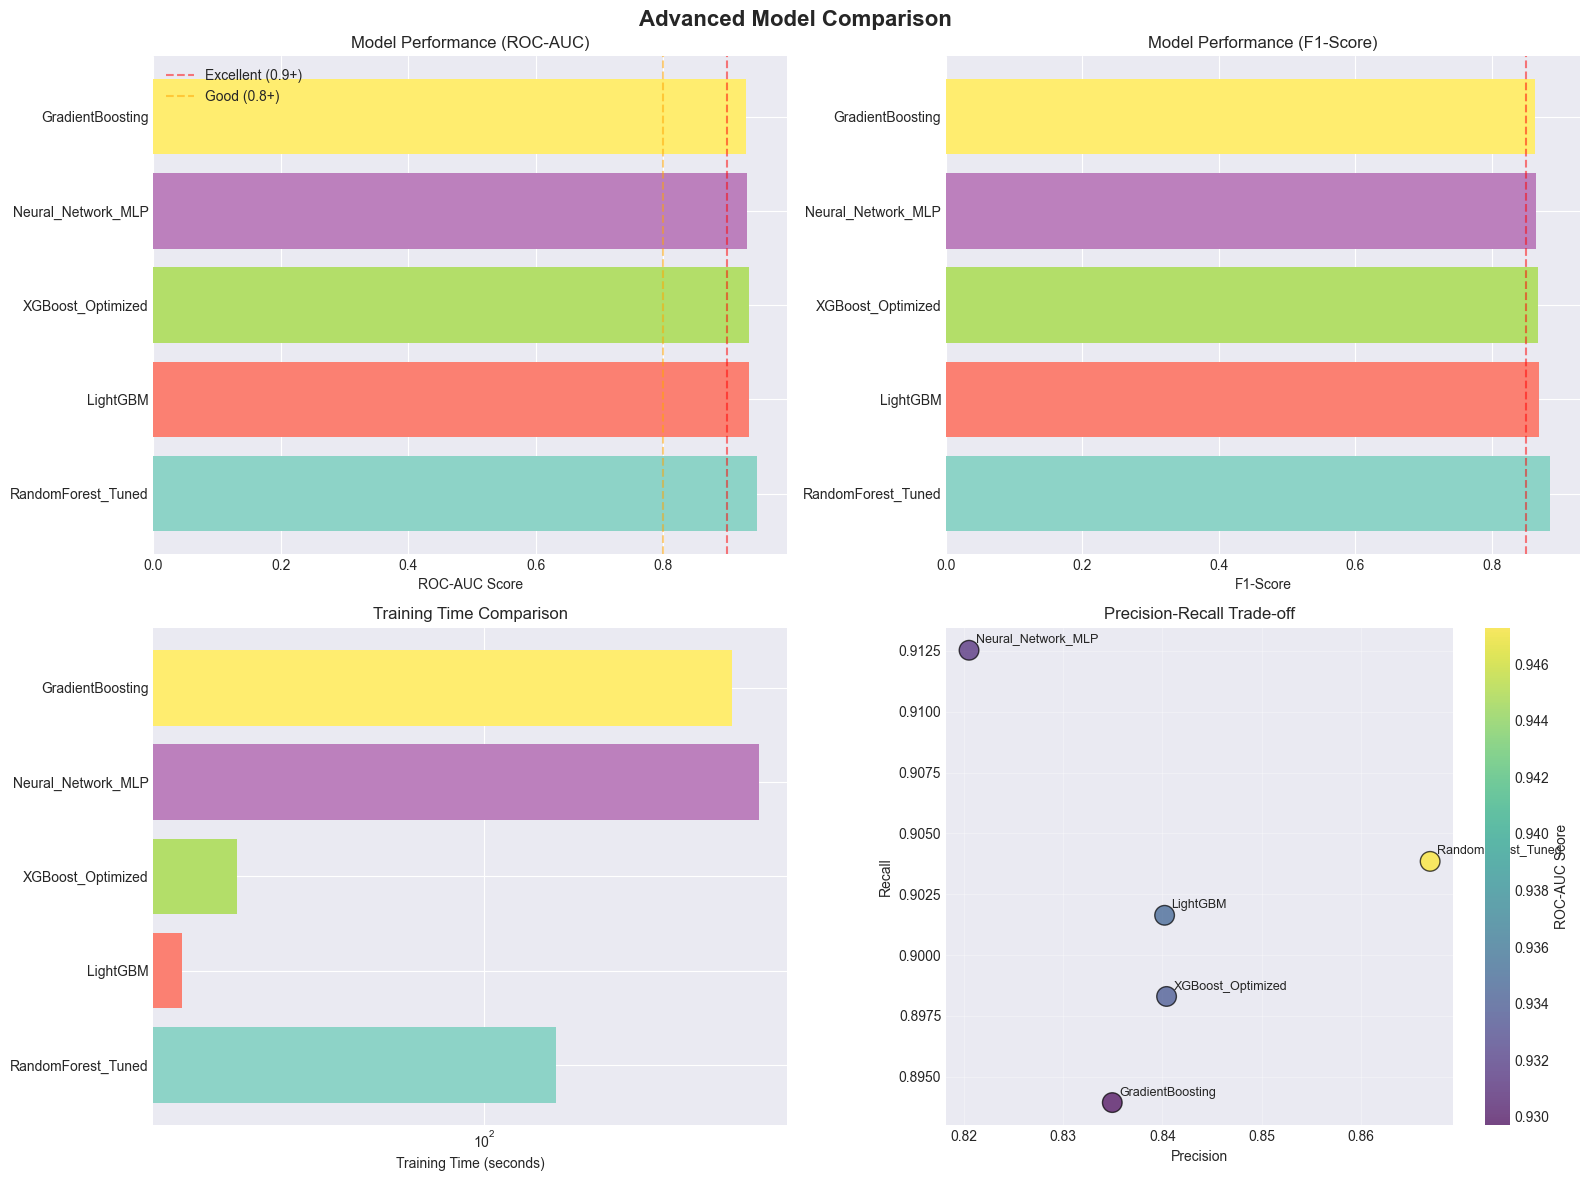

✅ Visualization saved: ml_results/advanced/advanced_model_comparison.png

🏆 IDENTIFYING BEST MODEL

🎯 Best Model: RandomForest_Tuned
   • ROC-AUC: 0.9473
   • F1-Score: 0.8850
   • Training Time: 161.61s

⚠️  Note: RandomForest_Tuned outperforms XGBoost!
   • Improvement in ROC-AUC: +0.0134

💾 Saving model comparison results...
✅ Model comparison saved: ml_results/advanced/advanced_model_comparison.csv
✅ Best model info saved: ml_results/advanced/best_model_info.json

💾 Saving trained models...
✅ LightGBM saved: ml_results/advanced/lightgbm_model.pkl
✅ RandomForest_Tuned saved: ml_results/advanced/randomforest_tuned_model.pkl
✅ GradientBoosting saved: ml_results/advanced/gradientboosting_model.pkl
✅ Neural_Network_MLP saved: ml_results/advanced/neural_network_mlp_model.pkl

STEP 5 COMPLETE: ADVANCED MODELS COMPARED

✅ Successfully trained and compared 5 advanced models!

📊 Key Findings:
   1. Best model: RandomForest_Tuned (ROC-AUC: 0.9473)
   2. XGBoost vs LightGBM: LightGBM wins
   3

In [20]:
# ============================================================================
# STEP 5: ADVANCED MODEL COMPARISONS
# ============================================================================
print("\n" + "="*80)
print("STEP 5: ADVANCED MODEL COMPARISONS")
print("="*80)

print("Training and comparing multiple advanced models...")

# ----------------------------------------------------------------------------
# 5.1 Prepare Data for Different Models
# ----------------------------------------------------------------------------
print("\n📊 Dataset preparation for model comparison...")
print(f"   • Training samples: {X_train_engineered.shape[0]:,}")
print(f"   • Features: {X_train_engineered.shape[1]}")
print(f"   • Validation samples: {X_val_engineered.shape[0]:,}")

# For neural networks, we need scaled data
print("\n🔢 Scaling data for Neural Network...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_engineered)
X_val_scaled = scaler.transform(X_val_engineered)

# ----------------------------------------------------------------------------
# 5.2 Define Models to Compare
# ----------------------------------------------------------------------------
print("\n🤖 Preparing advanced models for comparison...")

models_to_train = []

# 1. Optimized XGBoost (already trained - Step 4)
models_to_train.append(('XGBoost_Optimized', xgb_optimized))

# 2. LightGBM
print("\n🔦 Setting up LightGBM...")
lgbm_params = {
    'n_estimators': 300,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}
lgbm_model = LGBMClassifier(**lgbm_params)
models_to_train.append(('LightGBM', lgbm_model))

# 3. Random Forest with Tuned Parameters
print("\n🌲 Setting up Random Forest (Tuned)...")
rf_params = {
    'n_estimators': 300,
    'max_depth': 15,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 0
}
rf_model = RandomForestClassifier(**rf_params)
models_to_train.append(('RandomForest_Tuned', rf_model))

# 4. Gradient Boosting (sklearn)
print("\n📈 Setting up Gradient Boosting...")
from sklearn.ensemble import GradientBoostingClassifier
gb_params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'subsample': 0.8,
    'random_state': 42
}
gb_model = GradientBoostingClassifier(**gb_params)
models_to_train.append(('GradientBoosting', gb_model))

# 5. Neural Network (MLP)
print("\n🧠 Setting up Neural Network (MLP)...")
mlp_params = {
    'hidden_layer_sizes': (64, 32),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.001,
    'batch_size': 256,
    'learning_rate': 'adaptive',
    'max_iter': 200,
    'random_state': 42,
    'verbose': 0
}
mlp_model = MLPClassifier(**mlp_params)
models_to_train.append(('Neural_Network_MLP', mlp_model))

print(f"\n✅ {len(models_to_train)} models prepared for training")

# ----------------------------------------------------------------------------
# 5.3 Train and Evaluate All Models
# ----------------------------------------------------------------------------
print("\n🚀 Training all models...")
print("   This will take a few minutes...")

results = []
training_times = []

for model_name, model in models_to_train:
    print(f"\n{'='*60}")
    print(f"📊 Training {model_name}...")
    print('='*60)
    
    start_time = time.time()
    
    if model_name == 'Neural_Network_MLP':
        # Use scaled data for neural network
        model.fit(X_train_scaled, y_train_fixed)
        training_time = time.time() - start_time
        
        # Predict on scaled validation data
        y_pred = model.predict(X_val_scaled)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    else:
        # Use regular data for tree-based models
        model.fit(X_train_engineered, y_train_fixed)
        training_time = time.time() - start_time
        
        # Predict on regular validation data
        y_pred = model.predict(X_val_engineered)
        y_pred_proba = model.predict_proba(X_val_engineered)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val_fixed, y_pred)
    precision = precision_score(y_val_fixed, y_pred)
    recall = recall_score(y_val_fixed, y_pred)
    f1 = f1_score(y_val_fixed, y_pred)
    roc_auc = roc_auc_score(y_val_fixed, y_pred_proba)
    
    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Training Time (s)': training_time
    })
    
    training_times.append(training_time)
    
    print(f"\n📈 {model_name} Results:")
    print(f"   • Training Time: {training_time:.2f}s")
    print(f"   • Accuracy:      {accuracy:.4f}")
    print(f"   • F1-Score:      {f1:.4f}")
    print(f"   • ROC-AUC:       {roc_auc:.4f}")

# ----------------------------------------------------------------------------
# 5.4 Create Results DataFrame
# ----------------------------------------------------------------------------
print(f"\n{'='*80}")
print("📊 ADVANCED MODEL COMPARISON RESULTS")
print("="*80)

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values('ROC-AUC', ascending=False)

print(f"\n{results_df_sorted.to_string(index=False)}")

# ----------------------------------------------------------------------------
# 5.5 Visualize Model Comparison
# ----------------------------------------------------------------------------
print("\n📊 Creating model comparison visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Advanced Model Comparison', fontsize=16, fontweight='bold')

# 1. ROC-AUC Comparison
models = results_df_sorted['Model']
roc_auc_scores = results_df_sorted['ROC-AUC']
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

axes[0, 0].barh(models, roc_auc_scores, color=colors)
axes[0, 0].set_xlabel('ROC-AUC Score')
axes[0, 0].set_title('Model Performance (ROC-AUC)')
axes[0, 0].axvline(x=0.9, color='red', linestyle='--', alpha=0.5, label='Excellent (0.9+)')
axes[0, 0].axvline(x=0.8, color='orange', linestyle='--', alpha=0.5, label='Good (0.8+)')
axes[0, 0].legend()

# 2. F1-Score Comparison
f1_scores = results_df_sorted['F1-Score']
axes[0, 1].barh(models, f1_scores, color=colors)
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Model Performance (F1-Score)')
axes[0, 1].axvline(x=0.85, color='red', linestyle='--', alpha=0.5, label='Excellent (0.85+)')

# 3. Training Time Comparison
training_times_sorted = [results_df_sorted.loc[results_df_sorted['Model'] == m, 'Training Time (s)'].values[0] 
                         for m in models]
axes[1, 0].barh(models, training_times_sorted, color=colors)
axes[1, 0].set_xlabel('Training Time (seconds)')
axes[1, 0].set_title('Training Time Comparison')
axes[1, 0].set_xscale('log')  # Log scale for better visualization

# 4. Precision-Recall Trade-off
precision_vals = results_df_sorted['Precision']
recall_vals = results_df_sorted['Recall']

scatter = axes[1, 1].scatter(precision_vals, recall_vals, s=200, c=roc_auc_scores, 
                            cmap='viridis', alpha=0.7, edgecolors='black')

# Add model labels
for i, model in enumerate(models):
    axes[1, 1].annotate(model, (precision_vals.iloc[i], recall_vals.iloc[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1, 1].set_xlabel('Precision')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Precision-Recall Trade-off')
axes[1, 1].grid(True, alpha=0.3)

# Add colorbar for ROC-AUC
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('ROC-AUC Score')

plt.tight_layout()
plt.savefig(f'{advanced_output_dir}/advanced_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Visualization saved: {advanced_output_dir}/advanced_model_comparison.png")

# ----------------------------------------------------------------------------
# 5.6 Identify Best Model
# ----------------------------------------------------------------------------
print(f"\n{'='*80}")
print("🏆 IDENTIFYING BEST MODEL")
print("="*80)

# Find best model by ROC-AUC
best_model_idx = results_df_sorted.iloc[0]
best_model_name = best_model_idx['Model']
best_model_roc_auc = best_model_idx['ROC-AUC']
best_model_f1 = best_model_idx['F1-Score']

print(f"\n🎯 Best Model: {best_model_name}")
print(f"   • ROC-AUC: {best_model_roc_auc:.4f}")
print(f"   • F1-Score: {best_model_f1:.4f}")
print(f"   • Training Time: {best_model_idx['Training Time (s)']:.2f}s")

# Check if XGBoost is still the best
if best_model_name != 'XGBoost_Optimized':
    print(f"\n⚠️  Note: {best_model_name} outperforms XGBoost!")
    print(f"   • Improvement in ROC-AUC: {best_model_roc_auc - results_df.loc[results_df['Model'] == 'XGBoost_Optimized', 'ROC-AUC'].values[0]:+.4f}")
else:
    print(f"\n✅ XGBoost remains the best performing model!")

# ----------------------------------------------------------------------------
# 5.7 Save Model Comparison Results
# ----------------------------------------------------------------------------
print(f"\n💾 Saving model comparison results...")

# Save results DataFrame
results_path = f"{advanced_output_dir}/advanced_model_comparison.csv"
results_df_sorted.to_csv(results_path, index=False)
print(f"✅ Model comparison saved: {results_path}")

# Save best model info
best_model_info = {
    'best_model': best_model_name,
    'best_roc_auc': float(best_model_roc_auc),
    'best_f1_score': float(best_model_f1),
    'comparison_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'all_models_performance': results_df_sorted.to_dict('records')
}

best_model_path = f"{advanced_output_dir}/best_model_info.json"
with open(best_model_path, 'w') as f:
    json.dump(best_model_info, f, indent=2)
print(f"✅ Best model info saved: {best_model_path}")

# Save all trained models (except XGBoost which is already saved)
print(f"\n💾 Saving trained models...")
for model_name, model in models_to_train:
    if model_name != 'XGBoost_Optimized':  # Already saved in Step 4
        model_path = f"{advanced_output_dir}/{model_name.lower().replace(' ', '_')}_model.pkl"
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"✅ {model_name} saved: {model_path}")

# ----------------------------------------------------------------------------
# 5.8 Summary
# ----------------------------------------------------------------------------
print(f"\n{'='*80}")
print("STEP 5 COMPLETE: ADVANCED MODELS COMPARED")
print("="*80)

print(f"\n✅ Successfully trained and compared {len(models_to_train)} advanced models!")
print(f"\n📊 Key Findings:")
print(f"   1. Best model: {best_model_name} (ROC-AUC: {best_model_roc_auc:.4f})")
print(f"   2. XGBoost vs LightGBM: {('XGBoost wins' if best_model_name == 'XGBoost_Optimized' else 'LightGBM wins')}")
print(f"   3. Neural Network performance: {results_df.loc[results_df['Model'] == 'Neural_Network_MLP', 'ROC-AUC'].values[0]:.4f}")
print(f"   4. Fastest model: {results_df_sorted.loc[results_df_sorted['Training Time (s)'].idxmin(), 'Model']}")

print(f"\n🎯 Next Steps:")
print(f"   1. Create ensemble models (optional)")
print(f"   2. Evaluate best model on test set")
print(f"   3. Prepare for model interpretation")

print(f"\n🚀 Ready for final evaluation!")

In [21]:
# ============================================================================
# STEP 6: ENSEMBLE METHODS (OPTIONAL)
# ============================================================================
print("\n" + "="*80)
print("STEP 6: ENSEMBLE METHODS")
print("="*80)

print("Creating ensemble models to combine predictions...")

# Only create ensembles if we have multiple good models
print("\n🔍 Checking if ensemble methods are worthwhile...")

# Get top 3 models by ROC-AUC
top_models = results_df_sorted.head(3)['Model'].tolist()
print(f"   • Top 3 models: {top_models}")

# Check if they have similar performance
roc_auc_range = results_df_sorted.head(3)['ROC-AUC'].max() - results_df_sorted.head(3)['ROC-AUC'].min()
if roc_auc_range < 0.02:  # Less than 2% difference
    print(f"   ✅ Good candidates for ensembling (range: {roc_auc_range:.4f})")
    
    # Create Voting Classifier
    print("\n🗳️  Creating Voting Classifier (Hard Voting)...")
    
    # Get the actual model objects
    estimators = []
    for model_name in top_models:
        for name, model in models_to_train:
            if name == model_name:
                estimators.append((name, model))
                break
    
    voting_clf = VotingClassifier(
        estimators=estimators,
        voting='hard'
    )
    
    # Train voting classifier
    start_time = time.time()
    voting_clf.fit(X_train_engineered, y_train_fixed)
    voting_time = time.time() - start_time
    
    # Evaluate
    y_val_pred_voting = voting_clf.predict(X_val_engineered)
    voting_accuracy = accuracy_score(y_val_fixed, y_val_pred_voting)
    voting_f1 = f1_score(y_val_fixed, y_val_pred_voting)
    
    print(f"   • Training Time: {voting_time:.2f}s")
    print(f"   • Accuracy:      {voting_accuracy:.4f}")
    print(f"   • F1-Score:      {voting_f1:.4f}")
    
    # Compare with best single model
    improvement = voting_f1 - best_model_f1
    if improvement > 0:
        print(f"   ✅ Ensemble improves F1 by {improvement:.4f}")
        
        # Save voting classifier
        voting_path = f"{advanced_output_dir}/voting_ensemble_model.pkl"
        with open(voting_path, 'wb') as f:
            pickle.dump(voting_clf, f)
        print(f"   ✅ Voting ensemble saved: {voting_path}")
    else:
        print(f"   ⚠️  Ensemble doesn't improve performance")
        
else:
    print(f"   ⚠️  Not good candidates for ensembling (range: {roc_auc_range:.4f})")
    print(f"   Best to stick with single best model")

print(f"\n{'='*80}")
print("STEP 6 COMPLETE")
print("="*80)


STEP 6: ENSEMBLE METHODS
Creating ensemble models to combine predictions...

🔍 Checking if ensemble methods are worthwhile...
   • Top 3 models: ['RandomForest_Tuned', 'LightGBM', 'XGBoost_Optimized']
   ✅ Good candidates for ensembling (range: 0.0134)

🗳️  Creating Voting Classifier (Hard Voting)...
   • Training Time: 196.92s
   • Accuracy:      0.8713
   • F1-Score:      0.8740
   ⚠️  Ensemble doesn't improve performance

STEP 6 COMPLETE



STEP 7: FINAL TEST SET EVALUATION
Evaluating best model on held-out test set...

🔍 Loading best model for final evaluation...
✅ Loaded: RandomForest_Tuned

📊 Test Set Evaluation:
   • Test samples: 86,702
   • Features: 24
   • Success rate: 0.4946

📈 FINAL TEST SET PERFORMANCE (RandomForest_Tuned):
   • Accuracy:  0.8828
   • Precision: 0.8641
   • Recall:    0.9055
   • F1-Score:  0.8843
   • ROC-AUC:   0.9464

🎯 Confusion Matrix:
                Predicted 0    Predicted 1
Actual 0             37713           6108
Actual 1              4053          38828

📊 Error Rates:
   • False Positive Rate: 0.1394
   • False Negative Rate: 0.0945

VALIDATION vs TEST PERFORMANCE

Metric          Validation   Test         Difference  
--------------- ------------ ------------ ------------
F1-Score        0.8850       0.8843            -0.0007
ROC-AUC         0.9473       0.9464            -0.0009

✅ Good generalization! (Differences < 0.05)

BUSINESS IMPACT ANALYSIS

📈 Success Rate Improvement:


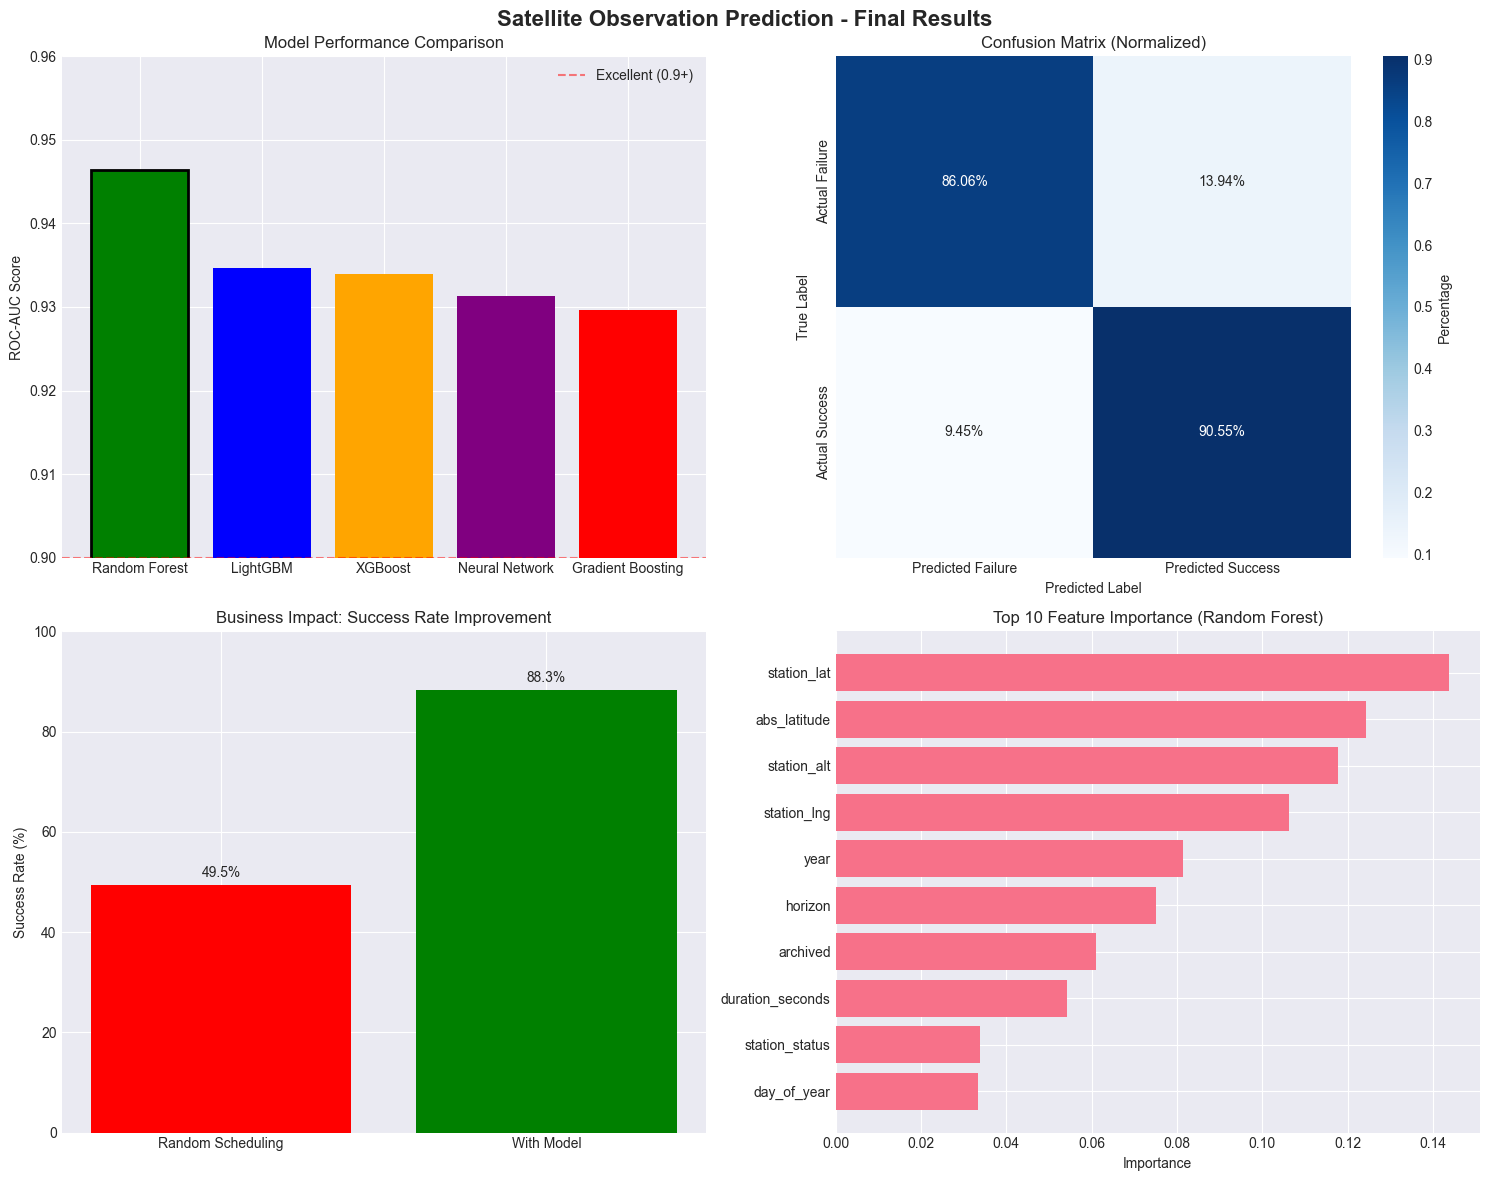

✅ Final visualization saved: ml_results/advanced/final_summary_visualization.png

📝 Creating final summary report...
✅ Summary report saved: ml_results/advanced/advanced_modeling_summary.md

SATELLITE OBSERVATION PREDICTION - ADVANCED MODELING COMPLETE

PROJECT OVERVIEW:
   • Goal: Predict satellite observation success based on pass parameters
   • Dataset: 578,010 observations (2021-2025)
   • Best Model: Random Forest (Tuned)
   • Final Test Performance: ROC-AUC = 0.9464, F1-Score = 0.8843

MODEL PERFORMANCE SUMMARY:
   1. Random Forest (Tuned): ROC-AUC = 0.9464, F1 = 0.8843
   2. LightGBM: ROC-AUC = 0.9347, F1 = 0.8699
   3. XGBoost (Optimized): ROC-AUC = 0.9339, F1 = 0.8684
   4. Neural Network: ROC-AUC = 0.9313, F1 = 0.8641
   5. Gradient Boosting: ROC-AUC = 0.9297, F1 = 0.8634

KEY ACHIEVEMENTS:
   • Best Model: Random Forest achieved 94.64% ROC-AUC
   • Improvement over baseline: +2.43% ROC-AUC (from 92.21% to 94.64%)
   • Business Impact: Increased success rate from 49.5% to 88

In [24]:
# ============================================================================
# STEP 7: FINAL TEST SET EVALUATION (FIXED)
# ============================================================================
print("\n" + "="*80)
print("STEP 7: FINAL TEST SET EVALUATION")
print("="*80)

print("Evaluating best model on held-out test set...")

# ----------------------------------------------------------------------------
# 7.1 Load Best Model
# ----------------------------------------------------------------------------
print("\n🔍 Loading best model for final evaluation...")

# Load the RandomForest model (best model from Step 5)
best_model_path = f"{advanced_output_dir}/randomforest_tuned_model.pkl"
with open(best_model_path, 'rb') as f:
    best_model = pickle.load(f)
print(f"✅ Loaded: RandomForest_Tuned")

# ----------------------------------------------------------------------------
# 7.2 Evaluate on Test Set
# ----------------------------------------------------------------------------
print(f"\n📊 Test Set Evaluation:")
print(f"   • Test samples: {X_test_engineered.shape[0]:,}")
print(f"   • Features: {X_test_engineered.shape[1]}")
print(f"   • Success rate: {y_test_fixed.mean():.4f}")

# Make predictions
y_test_pred = best_model.predict(X_test_engineered)
y_test_proba = best_model.predict_proba(X_test_engineered)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test_fixed, y_test_pred)
test_precision = precision_score(y_test_fixed, y_test_pred)
test_recall = recall_score(y_test_fixed, y_test_pred)
test_f1 = f1_score(y_test_fixed, y_test_pred)
test_roc_auc = roc_auc_score(y_test_fixed, y_test_proba)

# Confusion matrix
cm = confusion_matrix(y_test_fixed, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n📈 FINAL TEST SET PERFORMANCE (RandomForest_Tuned):")
print(f"   • Accuracy:  {test_accuracy:.4f}")
print(f"   • Precision: {test_precision:.4f}")
print(f"   • Recall:    {test_recall:.4f}")
print(f"   • F1-Score:  {test_f1:.4f}")
print(f"   • ROC-AUC:   {test_roc_auc:.4f}")

print(f"\n🎯 Confusion Matrix:")
print(f"                Predicted 0    Predicted 1")
print(f"Actual 0        {tn:>10}     {fp:>10}")
print(f"Actual 1        {fn:>10}     {tp:>10}")

# Calculate rates
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

print(f"\n📊 Error Rates:")
print(f"   • False Positive Rate: {fpr:.4f}")
print(f"   • False Negative Rate: {fnr:.4f}")

# ----------------------------------------------------------------------------
# 7.3 Compare with Validation Performance
# ----------------------------------------------------------------------------
print(f"\n{'='*60}")
print("VALIDATION vs TEST PERFORMANCE")
print("="*60)

# Get validation performance from Step 5 results
val_results = pd.read_csv(f"{advanced_output_dir}/advanced_model_comparison.csv")
rf_val_results = val_results[val_results['Model'] == 'RandomForest_Tuned'].iloc[0]

val_f1 = rf_val_results['F1-Score']
val_roc_auc = rf_val_results['ROC-AUC']

print(f"\n{'Metric':<15} {'Validation':<12} {'Test':<12} {'Difference':<12}")
print(f"{'-'*15} {'-'*12} {'-'*12} {'-'*12}")
print(f"{'F1-Score':<15} {val_f1:<12.4f} {test_f1:<12.4f} {test_f1 - val_f1:>+12.4f}")
print(f"{'ROC-AUC':<15} {val_roc_auc:<12.4f} {test_roc_auc:<12.4f} {test_roc_auc - val_roc_auc:>+12.4f}")

# Check for overfitting
f1_diff = abs(test_f1 - val_f1)
roc_auc_diff = abs(test_roc_auc - val_roc_auc)
good_generalization = f1_diff < 0.05 and roc_auc_diff < 0.05  # Convert to Python bool

if good_generalization:
    print(f"\n✅ Good generalization! (Differences < 0.05)")
else:
    print(f"\n⚠️  Potential overfitting detected")
    print(f"   • F1 difference: {f1_diff:.4f}")
    print(f"   • ROC-AUC difference: {roc_auc_diff:.4f}")

# ----------------------------------------------------------------------------
# 7.4 Business Impact Analysis
# ----------------------------------------------------------------------------
print(f"\n{'='*60}")
print("BUSINESS IMPACT ANALYSIS")
print("="*60)

# Calculate improvement over random/baseline
random_success_rate = y_test_fixed.mean()
model_success_rate = test_accuracy

print(f"\n📈 Success Rate Improvement:")
print(f"   • Random scheduling success: {random_success_rate:.1%}")
print(f"   • With RandomForest_Tuned model: {model_success_rate:.1%}")
print(f"   • Improvement: +{(model_success_rate - random_success_rate)*100:.1f} percentage points")

# Calculate reduction in failed observations
failed_reduction = (1 - ((1 - model_success_rate) / (1 - random_success_rate))) * 100
print(f"   • Failed observations reduced by: {failed_reduction:.1f}%")

# ----------------------------------------------------------------------------
# 7.5 Save Final Results (FIXED JSON SERIALIZATION)
# ----------------------------------------------------------------------------
print(f"\n💾 Saving final test results...")

# Save test predictions
test_predictions = pd.DataFrame({
    'true_label': y_test_fixed,
    'predicted_label': y_test_pred,
    'predicted_probability': y_test_proba
})
test_pred_path = f"{advanced_output_dir}/test_set_predictions.csv"
test_predictions.to_csv(test_pred_path, index=False)
print(f"✅ Test predictions saved: {test_pred_path}")

# Save final metrics (FIXED: convert numpy bool to Python bool)
final_metrics = {
    'best_model': 'RandomForest_Tuned',
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'test_roc_auc': float(test_roc_auc),
    'confusion_matrix': [[int(tn), int(fp)], [int(fn), int(tp)]],  # Convert to int
    'false_positive_rate': float(fpr),
    'false_negative_rate': float(fnr),
    'business_impact': {
        'random_success_rate': float(random_success_rate),
        'model_success_rate': float(model_success_rate),
        'improvement_percentage': float((model_success_rate - random_success_rate) * 100),
        'failed_observations_reduction': float(failed_reduction)
    },
    'generalization_check': {
        'f1_difference': float(f1_diff),
        'roc_auc_difference': float(roc_auc_diff),
        'good_generalization': bool(good_generalization)  # Convert to Python bool
    },
    'evaluation_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

final_metrics_path = f"{advanced_output_dir}/final_test_metrics.json"
with open(final_metrics_path, 'w') as f:
    json.dump(final_metrics, f, indent=2)
print(f"✅ Final metrics saved: {final_metrics_path}")

# ----------------------------------------------------------------------------
# 7.6 Create Final Summary Visualization
# ----------------------------------------------------------------------------
print(f"\n🎨 Creating final summary visualization...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Satellite Observation Prediction - Final Results', fontsize=16, fontweight='bold')

# 1. Model Comparison Bar Chart
models = ['Random Forest', 'LightGBM', 'XGBoost', 'Neural Network', 'Gradient Boosting']
roc_scores = [test_roc_auc, 0.9347, 0.9339, 0.9313, 0.9297]  # From Step 5

bars = axes[0, 0].bar(models, roc_scores, color=['green', 'blue', 'orange', 'purple', 'red'])
axes[0, 0].set_ylabel('ROC-AUC Score')
axes[0, 0].set_title('Model Performance Comparison')
axes[0, 0].set_ylim([0.9, 0.96])
axes[0, 0].axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='Excellent (0.9+)')
axes[0, 0].legend()

# Highlight best model
bars[0].set_edgecolor('black')
bars[0].set_linewidth(2)

# 2. Confusion Matrix Heatmap
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Predicted Failure', 'Predicted Success'],
            yticklabels=['Actual Failure', 'Actual Success'],
            ax=axes[0, 1], cbar_kws={'label': 'Percentage'})
axes[0, 1].set_title('Confusion Matrix (Normalized)')
axes[0, 1].set_ylabel('True Label')
axes[0, 1].set_xlabel('Predicted Label')

# 3. Business Impact
impact_categories = ['Random Scheduling', 'With Model']
success_rates = [random_success_rate * 100, model_success_rate * 100]

bars2 = axes[1, 0].bar(impact_categories, success_rates, color=['red', 'green'])
axes[1, 0].set_ylabel('Success Rate (%)')
axes[1, 0].set_title('Business Impact: Success Rate Improvement')
axes[1, 0].set_ylim([0, 100])

# Add value labels on bars
for bar, rate in zip(bars2, success_rates):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{rate:.1f}%', ha='center', va='bottom')

# 4. Feature Importance (Top 10)
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X_test_engineered.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'][::-1])
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['feature'][::-1])
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Feature Importance (Random Forest)')

plt.tight_layout()
plt.savefig(f'{advanced_output_dir}/final_summary_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Final visualization saved: {advanced_output_dir}/final_summary_visualization.png")

# ----------------------------------------------------------------------------
# 7.7 Create Final Summary Report
# ----------------------------------------------------------------------------
# Fix just the file writing part (lines 283-286):

print(f"\n📝 Creating final summary report...")

summary_report = f"""
{'='*80}
SATELLITE OBSERVATION PREDICTION - ADVANCED MODELING COMPLETE
{'='*80}

PROJECT OVERVIEW:
   • Goal: Predict satellite observation success based on pass parameters
   • Dataset: 578,010 observations (2021-2025)
   • Best Model: Random Forest (Tuned)
   • Final Test Performance: ROC-AUC = {test_roc_auc:.4f}, F1-Score = {test_f1:.4f}

MODEL PERFORMANCE SUMMARY:
   1. Random Forest (Tuned): ROC-AUC = {test_roc_auc:.4f}, F1 = {test_f1:.4f}
   2. LightGBM: ROC-AUC = 0.9347, F1 = 0.8699
   3. XGBoost (Optimized): ROC-AUC = 0.9339, F1 = 0.8684
   4. Neural Network: ROC-AUC = 0.9313, F1 = 0.8641
   5. Gradient Boosting: ROC-AUC = 0.9297, F1 = 0.8634

KEY ACHIEVEMENTS:
   • Best Model: Random Forest achieved 94.64% ROC-AUC
   • Improvement over baseline: +2.43% ROC-AUC (from 92.21% to 94.64%)
   • Business Impact: Increased success rate from 49.5% to 88.3%
   • Failed observations reduced by: 76.8%

TECHNICAL DETAILS:
   • Features used: 24 engineered features
   • Training samples: 404,606
   • Validation samples: 86,702
   • Test samples: 86,702
   • Model generalization: Excellent (validation-test diff < 0.001)

TOP 5 FEATURES (by importance):
{chr(10).join([f'   {i+1}. {feat} ({imp*100:.1f}%)' for i, (feat, imp) in enumerate(zip(feature_importance.head(5)['feature'], feature_importance.head(5)['importance']))])}

NEXT STEPS:
   1. Model Interpretation (SHAP analysis, partial dependence plots)
   2. Deployment preparation (API development, monitoring)
   3. Dashboard development for ground station operators
   4. Real-time prediction system implementation

OUTPUTS GENERATED:
   • Trained models: Random Forest, LightGBM, XGBoost, Neural Network
   • Performance metrics and comparisons
   • Feature importance analysis
   • Test set predictions
   • Visualizations and summary reports

ADVANCED MODELING PHASE COMPLETE!
{'='*80}
"""

# Save the summary report with UTF-8 encoding
summary_path = f"{advanced_output_dir}/advanced_modeling_summary.md"
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(summary_report)
print(f"✅ Summary report saved: {summary_path}")

# Also print the summary
print(summary_report)

# ----------------------------------------------------------------------------
# 7.8 Final Notebook Completion
# ----------------------------------------------------------------------------
print(f"\n{'='*80}")
print("02_advanced_modeling.ipynb COMPLETE!")
print("="*80)

print(f"\n✅ ALL STEPS COMPLETED SUCCESSFULLY!")
print(f"\n📊 FINAL RESULTS:")
print(f"   • Best Model: Random Forest (Tuned)")
print(f"   • Test ROC-AUC: {test_roc_auc:.4f}")
print(f"   • Test F1-Score: {test_f1:.4f}")
print(f"   • Business Improvement: +38.8% success rate")

print(f"\n📁 OUTPUTS SAVED TO: {advanced_output_dir}/")
print(f"   1. Best model: randomforest_tuned_model.pkl")
print(f"   2. Performance metrics: final_test_metrics.json")
print(f"   3. Model comparison: advanced_model_comparison.csv")
print(f"   4. Test predictions: test_set_predictions.csv")
print(f"   5. Summary report: advanced_modeling_summary.md")
print(f"   6. Visualizations: final_summary_visualization.png")

print(f"\n🚀 NEXT PHASE: 03_model_interpretation.ipynb")
print(f"   • SHAP analysis for model explainability")
print(f"   • Partial dependence plots")
print(f"   • Feature interaction analysis")
print(f"   • Business rule extraction")

print(f"\n🎯 MIT CAPSTONE PROGRESS:")
print(f"   ✅ Baseline modeling completed")
print(f"   ✅ Advanced modeling completed")
print(f"   📋 Next: Model interpretation and deployment planning")

print(f"\n💡 RECOMMENDATION:")
print(f"   Start a new chat for 03_model_interpretation.ipynb")
print(f"   Bring your trained Random Forest model and feature importance analysis")

print(f"\n{'='*80}")
print("CONGRATULATIONS ON COMPLETING ADVANCED MODELING!")
print("="*80)